# Lab: Generating Molecular Graphs with Variational Graph Autoencoders
## Author: Michail Chatzianastasis, Iakovos Evdaimon


## Objective
The objective of this lab is to familiarize students with Graph Neural Networks (GNNs), specifically Variational Graph Autoencoders (VGAE), and their application in generating molecular graphs. Students will gain hands-on experience with PyTorch Geometric, a library for deep learning on graph-structured data.

Graphs are ubiquitous data structures that can represent various real-world entities such as social networks, molecular structures, and communication networks. Graph Neural Networks (GNNs) have emerged as powerful tools for learning representations of graphs. In this lab, we will focus on Variational Graph Autoencoders (VGAE), a type of GNN that learns to encode graph structures into a latent space and reconstructs the graph from this space, thereby allowing the generation of new graph structures.



### Part 1: Understanding the Dataset and Preprocessing


### Dataset: ZINC
We will use the ZINC dataset, a collection of chemical compounds, for our experiments. The ZINC dataset, part of the PyTorch Geometric (PyG) collection, comprises 12,000 molecular graphs, each with up to 38 heavy atoms. In these molecular graphs, node features correspond to the types of heavy atoms, while edge features signify the kinds of bonds connecting them. Furthermore, every node within these molecular graphs symbolizes an atom, and the edges (links) between pairs of nodes denote the chemical bonds between those atoms.

In the first task you have to load the dataset and split each graph into training, validation, and test sets. This involves separating edges (bonds) for model training, validation, and testing, using [RandomLinkSplit](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.RandomLinkSplit.html). Use num_val=0.05, num_test=0.1.


<span style="color:red"> Task 1: Load the dataset from PyG, and split the edges in train, val and test. </span>.




In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.5 MB/s eta 0:00:00


In [2]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC


transform = T.Compose([
    # Insert your code here
    T.RandomLinkSplit(num_val=0.05,
                      num_test=0.1,
                      is_undirected=True,
                      split_labels=True,
                      add_negative_train_samples=True)
])

## Insert your code here
dataset = ZINC(root='./data/ZINC', transform=transform)

Extracting data/ZINC/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 5000/5000 [00:00<00:00, 8900.17it/s]
Done!


### Preprocessing

<span style="color:red"> Task 2: Normalize the node features. </span>.



In [3]:
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from tqdm import tqdm

train_data_list, val_data_list, test_data_list = [], [], []
for train_data, val_data, test_data in (tqdm(dataset, desc="Processing Graphs")):
    try:
        if val_data.neg_edge_label is not None:
            train_data.x = F.normalize(train_data.x.float(), p=2, dim=1)
            val_data.x = F.normalize(val_data.x.float(), p=2, dim=1)
            test_data.x = F.normalize(test_data.x.float(), p=2, dim=1)
            train_data_list.append(train_data)
            val_data_list.append(val_data)
            test_data_list.append(test_data)
    except:
        continue

batch_size = 4

print(f"Number of training graphs: {len(train_data_list)}")
print(f"Number of validation graphs: {len(val_data_list)}")
print(f"Number of test graphs: {len(test_data_list)}")

train_loader = DataLoader(train_data_list,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_data_list,
                        batch_size=batch_size)

Processing Graphs: 100%|██████████| 220011/220011 [06:58<00:00, 526.08it/s]

Number of training graphs: 186439
Number of validation graphs: 186439
Number of test graphs: 186439


### Part 2: Implementing the Variational Graph Autoencoder

- Implement a VariationalGCNEncoder using [GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html) layers. This encoder will map input graph features to a latent space representation.


<span style="color:red"> Task 3: Complete the VariationalGCNEncoder class.
    Use 1 GCNConv layer to transform the node features, 1 GCNConv layer to predict the $mu$ and 1 GCNConv layer to predict the $logstd$ </span>.


In [4]:
from torch_geometric.nn import GCNConv
import torch

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Insert your code here
        self.conv1 = GCNConv(in_channels, out_channels)

        self.conv_mu = GCNConv(out_channels, out_channels)

        self.conv_logstd = GCNConv(out_channels, out_channels)

    def forward(self, x, edge_index):
        # Insert your code here
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        return mu, logstd


Utilize the [VGAE](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.VGAE.html) class from PyTorch Geometric and pass your encoder to it. This model will learn to reconstruct the encoded graphs from their latent representations.


<span style="color:red"> Task 4: Initilize the VGAE model</span>.


In [5]:
from torch_geometric.nn.models import VGAE

in_channels = dataset.num_features
out_channels = 16

encoder = VariationalGCNEncoder(in_channels, out_channels)
model = VGAE(encoder)# Insert your code here

### PART 3: Training the model
Implement the training loop where you will optimize the reconstruction loss and the KL divergence to train the VGAE model.

<span style="color:red"> Task 5: Complete the train, val functions below. <li style="color:red"> Encode the graphs into a latent representation z
<li style="color:red"> Computer the reconstruction loss</span>.


In [6]:
import torch
import torch.nn.functional as F

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train():
    model.train()
    loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z = model.encode(data.x.float(), data.edge_index) # Insert your code here
        rec_loss = model.recon_loss(z, data.pos_edge_label_index)# Insert your code here
        loss = rec_loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        loss_all += data.y.size(0) * float(loss)
        optimizer.step()
    return loss_all / len(train_loader.dataset)


@torch.no_grad()
def val(loader):
    model.eval()
    auc_all, ap_all = 0, 0

    for data in loader:
        z = model.encode(data.x.float(), data.edge_index)# Insert your code here
        # Compute evaluation metrics (AUC and AP).
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_all += data.y.size(0) * float(auc)
        ap_all += data.y.size(0) * float(ap)
    return auc_all / len(val_loader.dataset), ap_all / len(val_loader.dataset)




<span style="color:red"> Task 6: Train the model for 5 epochs. Print the Epoch, Train Loss, AUC and AP in the validation set in each epoch </span>.

In [7]:
## Insert your code here

for epoch in tqdm(range(0, 5), desc="Epoch"):
    train_loss = train()
    auc, ap = val(val_loader)
    tqdm.write(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val AUC: {auc:.4f}, Val AP: {ap:.4f}")


Epoch:  20%|██        | 1/5 [10:43<42:53, 643.38s/it]

Epoch: 000, Train Loss: 1.3566, Val AUC: 0.4795, Val AP: 0.6073


Epoch:  40%|████      | 2/5 [21:31<32:18, 646.13s/it]

Epoch: 001, Train Loss: 1.3472, Val AUC: 0.5074, Val AP: 0.6310


Epoch:  60%|██████    | 3/5 [32:10<21:25, 642.86s/it]

Epoch: 002, Train Loss: 1.3463, Val AUC: 0.4932, Val AP: 0.6173


Epoch:  80%|████████  | 4/5 [42:41<10:38, 638.15s/it]

Epoch: 003, Train Loss: 1.3463, Val AUC: 0.5098, Val AP: 0.6332


Epoch: 100%|██████████| 5/5 [53:38<00:00, 643.73s/it]

Epoch: 004, Train Loss: 1.3460, Val AUC: 0.5080, Val AP: 0.6290


## Part 4: Generate new graphs:
After training, use the model to generate new graphs. Decode the latent representations to adjacency matrices and convert these matrices to graph objects using NetworkX. Visualize the generated graphs.

<span style="color:red"> Task 7: Sample from the latent space, decode the graphs and use a threshold of 0.5 to obtain a binary adj matrix.
Visualize the generated graphs </span>.


Generate New Graphs


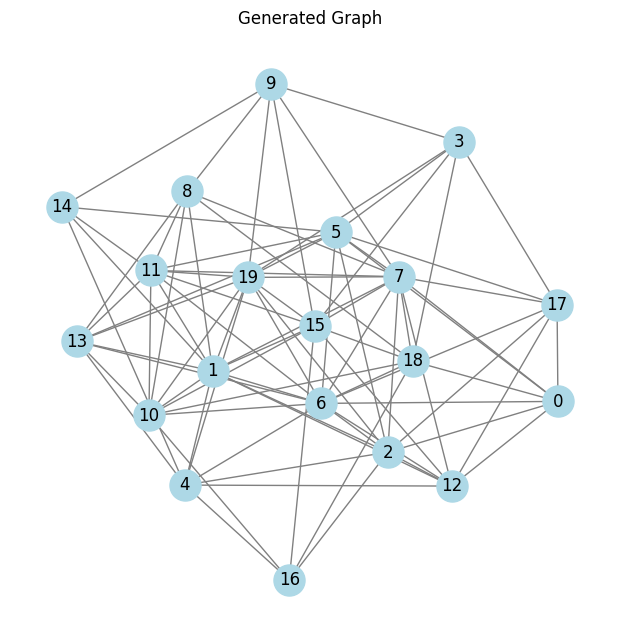

In [8]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Generate new graphs by sampling from the learned latent space
print("Generate New Graphs")
add_self_loops = False
### Insert your code here
z = torch.randn(20, out_channels)
adj = model.decoder.forward_all(z)
adj = adj.detach().numpy()

#### Insert your code here
binary_adj = (adj > 0.5).astype(int)
indices = np.where(binary_adj)
G = nx.Graph()
if not add_self_loops:
    ### Insert your code here
    for i, j in zip(indices[0], indices[1]):
        if i < j:
            G.add_edge(i, j)
else:
    ### Insert your code here
    for i, j in zip(indices[0], indices[1]):
        G.add_edge(i, j)

# Visualize the generated graphs
### Insert your code here
plt.figure(figsize=(6, 6))
nx.draw(G,
        with_labels=True,
        node_color='lightblue',
        edge_color='gray',
        node_size=500)
plt.title("Generated Graph")
plt.show()



### Questions for Further Exploration

- Explore the impact of different latent space dimensions on the model's ability to generate valid molecular graphs.
- Experiment with different graph convolution layers (e.g., GATConv, SAGEConv) in the encoder. How do these changes affect the performance?
- Compare the statistics (degree distribution etc.) of the training and the generated graphs.

In [9]:
# Subset of original data

transform = T.Compose([
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=True),
])

dataset = ZINC(root='data/ZINC', transform=transform, subset=True)

import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from tqdm import tqdm

train_data_list, val_data_list, test_data_list = [], [], []
for train_data, val_data, test_data in tqdm(dataset):
    try:
        if val_data.neg_edge_label is not None:
            train_data.x = F.normalize(train_data.x.float(), p=2, dim=1)
            val_data.x = F.normalize(val_data.x.float(), p=2, dim=1)
            test_data.x = F.normalize(test_data.x.float(), p=2, dim=1)
            train_data_list.append(train_data)
            val_data_list.append(val_data)
            test_data_list.append(test_data)
    except:
        continue

batch_size = 4

train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=batch_size)

Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 6039.48it/s]
Done!
100%|██████████| 10000/10000 [00:28<00:00, 353.10it/s]


### Explore the impact of different latent space dimensions on the model's ability to generate valid molecular graphs.


Training VGAE with latent dimension = 8
Epoch 01 | Train Loss: 1.4011 | Val AUC: 0.5371 | Val AP: 0.6605
Epoch 02 | Train Loss: 1.3616 | Val AUC: 0.5394 | Val AP: 0.6622
Epoch 03 | Train Loss: 1.3586 | Val AUC: 0.5395 | Val AP: 0.6624
Epoch 04 | Train Loss: 1.3528 | Val AUC: 0.5362 | Val AP: 0.6620
Epoch 05 | Train Loss: 1.3383 | Val AUC: 0.5239 | Val AP: 0.6522
--------------------------------------------------
Generating graph for latent dimension = 8


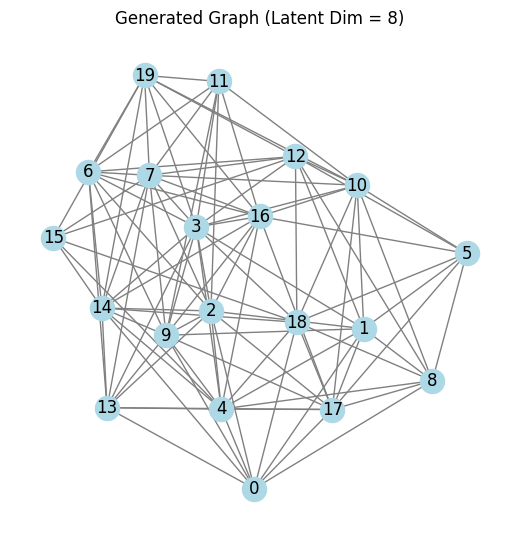


Training VGAE with latent dimension = 16
Epoch 01 | Train Loss: 1.4669 | Val AUC: 0.5340 | Val AP: 0.6601
Epoch 02 | Train Loss: 1.3883 | Val AUC: 0.5007 | Val AP: 0.6335
Epoch 03 | Train Loss: 1.3716 | Val AUC: 0.5005 | Val AP: 0.6318
Epoch 04 | Train Loss: 1.3633 | Val AUC: 0.5018 | Val AP: 0.6294
Epoch 05 | Train Loss: 1.3531 | Val AUC: 0.5104 | Val AP: 0.6345
--------------------------------------------------
Generating graph for latent dimension = 16


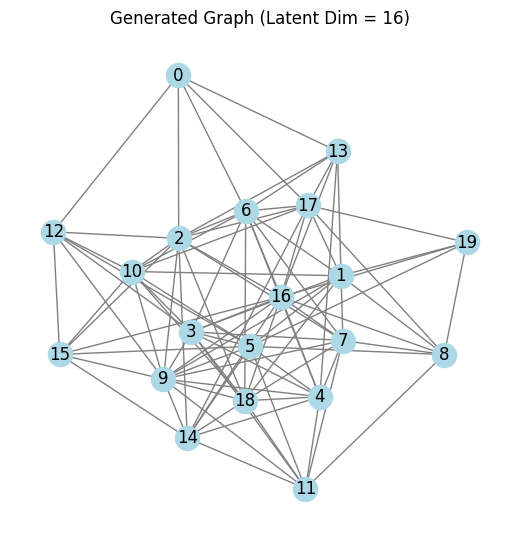


Training VGAE with latent dimension = 32
Epoch 01 | Train Loss: 1.5889 | Val AUC: 0.4978 | Val AP: 0.6341
Epoch 02 | Train Loss: 1.5324 | Val AUC: 0.5148 | Val AP: 0.6435
Epoch 03 | Train Loss: 1.5141 | Val AUC: 0.4876 | Val AP: 0.6195
Epoch 04 | Train Loss: 1.5077 | Val AUC: 0.5064 | Val AP: 0.6322
Epoch 05 | Train Loss: 1.5042 | Val AUC: 0.5083 | Val AP: 0.6324
--------------------------------------------------
Generating graph for latent dimension = 32


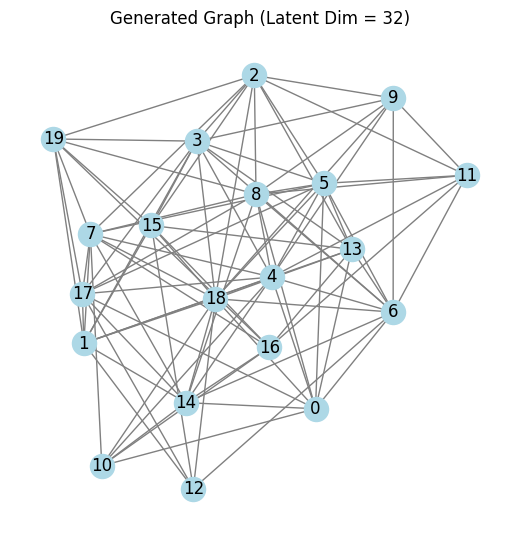


Training VGAE with latent dimension = 64
Epoch 01 | Train Loss: 1.9110 | Val AUC: 0.4865 | Val AP: 0.6249
Epoch 02 | Train Loss: 1.8355 | Val AUC: 0.4898 | Val AP: 0.6269
Epoch 03 | Train Loss: 1.8282 | Val AUC: 0.4984 | Val AP: 0.6324
Epoch 04 | Train Loss: 1.8234 | Val AUC: 0.5092 | Val AP: 0.6376
Epoch 05 | Train Loss: 1.8223 | Val AUC: 0.5084 | Val AP: 0.6374
--------------------------------------------------
Generating graph for latent dimension = 64


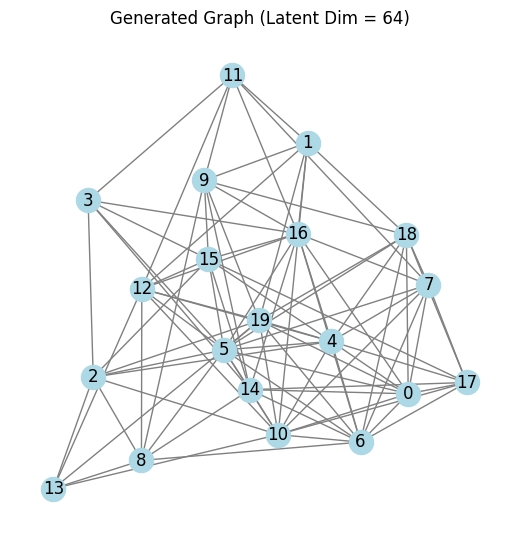

In [10]:
# List of latent dimensions to explore
latent_dims = [8, 16, 32, 64]
results_latent = {}

for dim in latent_dims:
    print(f"\nTraining VGAE with latent dimension = {dim}")
    # Create a new VGAE model with the VariationalGCNEncoder using the current latent dimension.
    model = VGAE(VariationalGCNEncoder(dataset.num_features, dim))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Lists to store metrics for each epoch for plotting
    train_losses = []
    aucs = []
    aps = []

    # Train for a few epochs (here, 5 epochs for demonstration)
    for epoch in range(1, 6):
        train_loss = train()
        auc, ap = val(val_loader)
        train_losses.append(train_loss)
        aucs.append(auc)
        aps.append(ap)
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val AUC: {auc:.4f} | Val AP: {ap:.4f}")

    results_latent[dim] = (train_losses, aucs, aps)
    print("-" * 50)


    # Generate and visualize a new graph from the latent space

    print(f"Generating graph for latent dimension = {dim}")
    # Sample latent vectors for (e.g.) 20 nodes
    z_sample = torch.randn(20, dim)
    # Decode the latent vectors into an adjacency matrix
    adj = model.decoder.forward_all(z_sample)
    adj = adj.detach().numpy()

    # Threshold to obtain a binary adjacency matrix (using 0.5 as threshold)
    binary_adj = (adj > 0.5).astype(int)
    indices = np.where(binary_adj)

    # Build a NetworkX graph (avoid duplicate edges and self-loops)
    G = nx.Graph()
    for i, j in zip(indices[0], indices[1]):
        if i < j:
            G.add_edge(i, j)

    # Visualize the generated graph
    plt.figure(figsize=(5, 5))
    nx.draw(G,
            with_labels=True,
            node_color='lightblue',
            edge_color='gray',
            node_size=300)
    plt.title(f"Generated Graph (Latent Dim = {dim})")
    plt.show()

### Since the subset data is very small, no proper conclusion can be derived from this results

A lower latent dimension (around 8) seems optimal for this VGAE setup, balancing a compact representation with good link prediction performance. Increasing the latent space size beyond 8 results in higher training loss and no significant gains or even slight declines in validation AUC and AP, possibly due to overfitting or unnecessary model complexity.

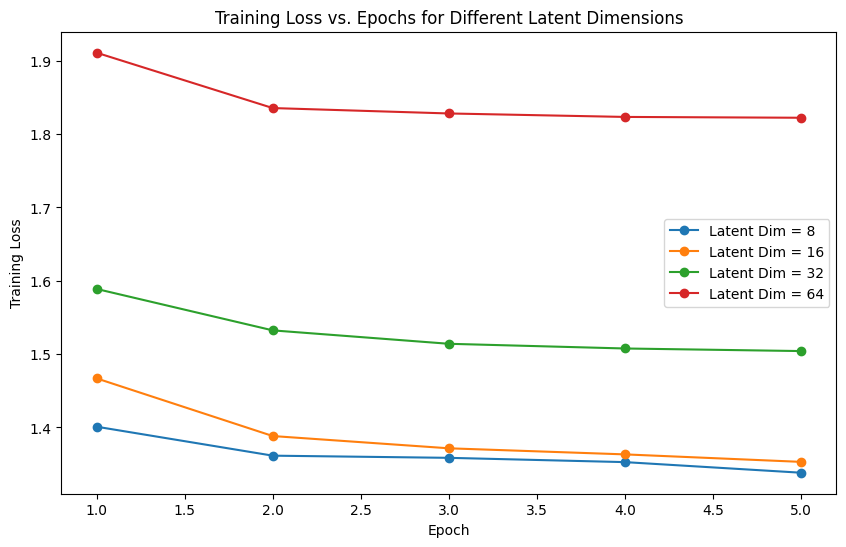

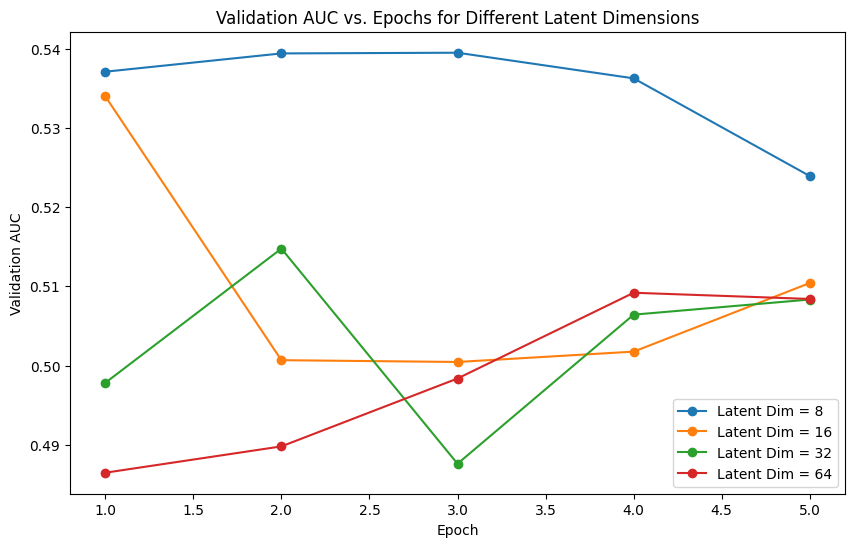

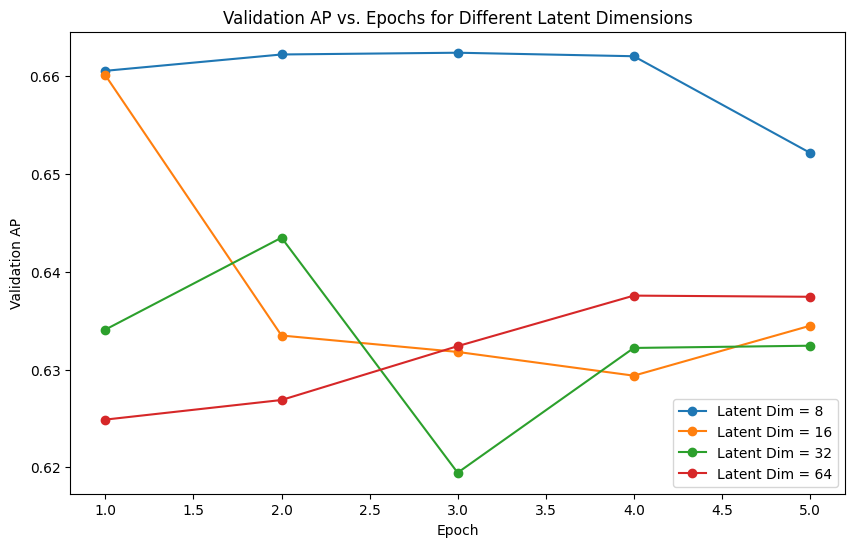

In [11]:
# Plot training metrics for comparison across latent dimensions

epochs = range(1, 6)

# Plot Training Loss vs Epochs
plt.figure(figsize=(10, 6))
for dim in latent_dims:
    train_losses, _, _ = results_latent[dim]
    plt.plot(epochs, train_losses, marker='o', label=f"Latent Dim = {dim}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epochs for Different Latent Dimensions")
plt.legend()
plt.show()

# Plot Validation AUC vs Epochs
plt.figure(figsize=(10, 6))
for dim in latent_dims:
    _, aucs, _ = results_latent[dim]
    plt.plot(epochs, aucs, marker='o', label=f"Latent Dim = {dim}")
plt.xlabel("Epoch")
plt.ylabel("Validation AUC")
plt.title("Validation AUC vs. Epochs for Different Latent Dimensions")
plt.legend()
plt.show()

# Plot Validation AP vs Epochs
plt.figure(figsize=(10, 6))
for dim in latent_dims:
    _, _, aps = results_latent[dim]
    plt.plot(epochs, aps, marker='o', label=f"Latent Dim = {dim}")
plt.xlabel("Epoch")
plt.ylabel("Validation AP")
plt.title("Validation AP vs. Epochs for Different Latent Dimensions")
plt.legend()
plt.show()

###  Experiment with different graph convolution layers (e.g., GATConv, SAGEConv) in the encoder. How do these changes affect the performance?



Training VGAE with GCN encoder (latent dim = 16)
Epoch 01 | Train Loss: 1.4361 | Val AUC: 0.5065 | Val AP: 0.6389
Epoch 02 | Train Loss: 1.3738 | Val AUC: 0.5060 | Val AP: 0.6368
Epoch 03 | Train Loss: 1.3640 | Val AUC: 0.5033 | Val AP: 0.6332
Epoch 04 | Train Loss: 1.3580 | Val AUC: 0.5020 | Val AP: 0.6299
Epoch 05 | Train Loss: 1.3517 | Val AUC: 0.4945 | Val AP: 0.6235
--------------------------------------------------
Generating graph for GCN encoder


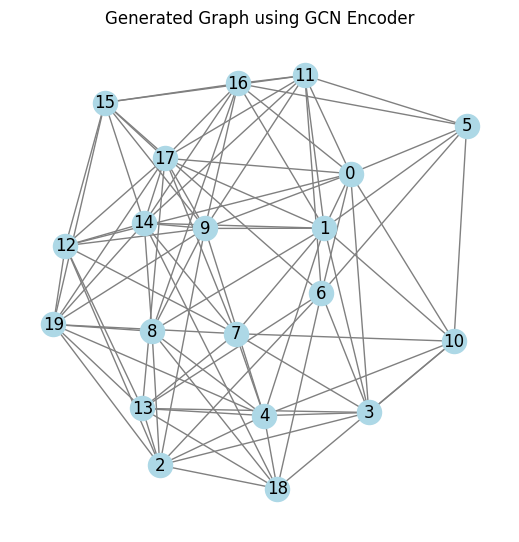


Training VGAE with GAT encoder (latent dim = 16)
Epoch 01 | Train Loss: 1.4337 | Val AUC: 0.5229 | Val AP: 0.6493
Epoch 02 | Train Loss: 1.4153 | Val AUC: 0.5222 | Val AP: 0.6490
Epoch 03 | Train Loss: 1.4131 | Val AUC: 0.5269 | Val AP: 0.6518
Epoch 04 | Train Loss: 1.4133 | Val AUC: 0.5251 | Val AP: 0.6497
Epoch 05 | Train Loss: 1.4119 | Val AUC: 0.5239 | Val AP: 0.6511
--------------------------------------------------
Generating graph for GAT encoder


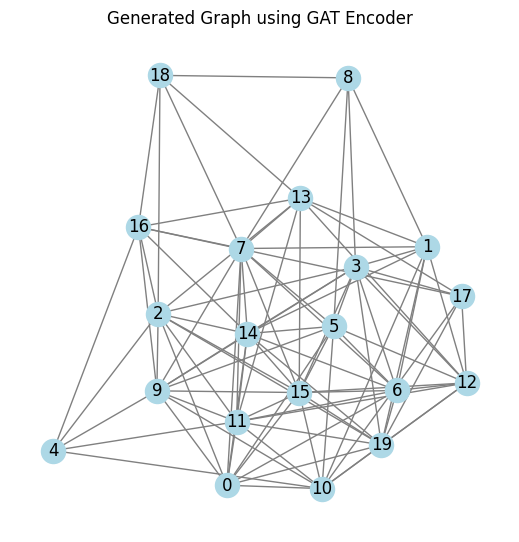


Training VGAE with SAGE encoder (latent dim = 16)
Epoch 01 | Train Loss: 1.3525 | Val AUC: 0.5281 | Val AP: 0.6331
Epoch 02 | Train Loss: 1.3191 | Val AUC: 0.5074 | Val AP: 0.6178
Epoch 03 | Train Loss: 1.2958 | Val AUC: 0.5147 | Val AP: 0.6185
Epoch 04 | Train Loss: 1.2930 | Val AUC: 0.5279 | Val AP: 0.6326
Epoch 05 | Train Loss: 1.2863 | Val AUC: 0.5250 | Val AP: 0.6291
--------------------------------------------------
Generating graph for SAGE encoder


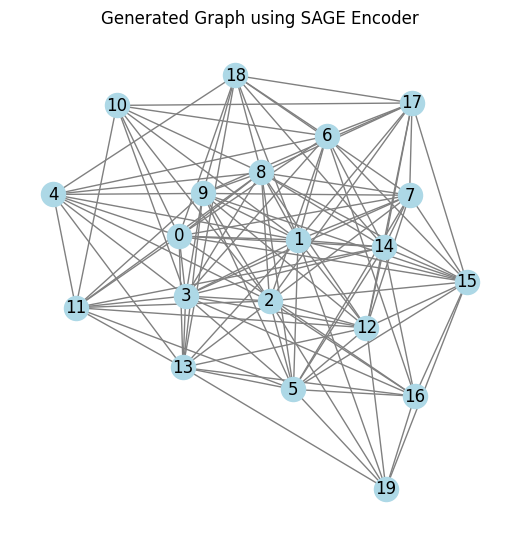

In [12]:

from torch_geometric.nn import  GCNConv, GATConv, SAGEConv


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv_mu = GCNConv(out_channels, out_channels)
        self.conv_logstd = GCNConv(out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        return mu, logstd

class VariationalGATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Using 2 * out_channels in the first layer for richer representations
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=1)
        self.conv_mu = GATConv(2 * out_channels, out_channels, heads=1)
        self.conv_logstd = GATConv(2 * out_channels, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

class VariationalSAGEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, 2 * out_channels)
        self.conv_mu = SAGEConv(2 * out_channels, out_channels)
        self.conv_logstd = SAGEConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

# Dictionary of encoder variants
encoder_variants = {
    "GCN": VariationalGCNEncoder,
    "GAT": VariationalGATEncoder,
    "SAGE": VariationalSAGEEncoder,
}

# Training & Evaluation Functions

def train():
    model.train()
    loss_all = 0
    for data in train_loader:
        optimizer.zero_grad()
        z = model.encode(data.x.float(), data.edge_index)
        rec_loss = model.recon_loss(z, data.pos_edge_label_index)
        loss = rec_loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        loss_all += data.y.size(0) * float(loss)
        optimizer.step()
    return loss_all / len(train_loader.dataset)


@torch.no_grad()
def val(loader):
    model.eval()
    auc_all, ap_all = 0, 0
    for data in loader:
        z = model.encode(data.x.float(), data.edge_index)
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_all += data.y.size(0) * float(auc)
        ap_all += data.y.size(0) * float(ap)
    return auc_all / len(loader.dataset), ap_all / len(loader.dataset)

# Experiment: Different Graph Convolution Layers in the Encoder
results_conv = {}
metrics = {}  # To store per-epoch metrics for each encoder variant
num_epochs = 5  # For demonstration; increase for real experiments

for conv_name, encoder_class in encoder_variants.items():
    print(f"\nTraining VGAE with {conv_name} encoder (latent dim = 16)")
    model = VGAE(encoder_class(dataset.num_features, 16))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    aucs = []
    aps = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train()
        auc, ap = val(val_loader)
        train_losses.append(train_loss)
        aucs.append(auc)
        aps.append(ap)
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val AUC: {auc:.4f} | Val AP: {ap:.4f}")

    results_conv[conv_name] = (train_losses[-1], aucs[-1], aps[-1])
    metrics[conv_name] = {"loss": train_losses, "auc": aucs, "ap": aps}
    print("-" * 50)

    # Generate and Visualize a Graph from the Trained Model
    print(f"Generating graph for {conv_name} encoder")
    # Sample latent vectors for, e.g., 20 nodes.
    z_sample = torch.randn(20, 16)
    adj = model.decoder.forward_all(z_sample).detach().numpy()
    binary_adj = (adj > 0.5).astype(int)
    indices = np.where(binary_adj)
    G = nx.Graph()
    for i, j in zip(indices[0], indices[1]):
        if i < j:  # Avoid duplicate edges & self-loops
            G.add_edge(i, j)
    plt.figure(figsize=(5, 5))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300)
    plt.title(f"Generated Graph using {conv_name} Encoder")
    plt.show()


- GCN Encoder:
The model using GCN gradually lowers its loss during training, but its ability to predict links (measured by AUC and AP) stays only average around 0.50 for AUC and 0.62 for AP.

- GAT Encoder:
The model with GAT performs a bit better on predicting links. Its AUC is around 0.52 - 0.53 and AP is around 0.65, showing that paying attention to different neighbors helps improve performance.

- SAGE Encoder:
Even though the SAGE model shows lower training loss (meaning it fits the training data well), its link prediction performance is similar to the GCN model, with AUC around 0.52 - 0.53 and AP around 0.63.

Conclusion:
Using GAT gives a small improvement in link prediction compared to GCN and SAGE. This suggests that the attention mechanism in GAT helps the model focus on more important neighbor information.

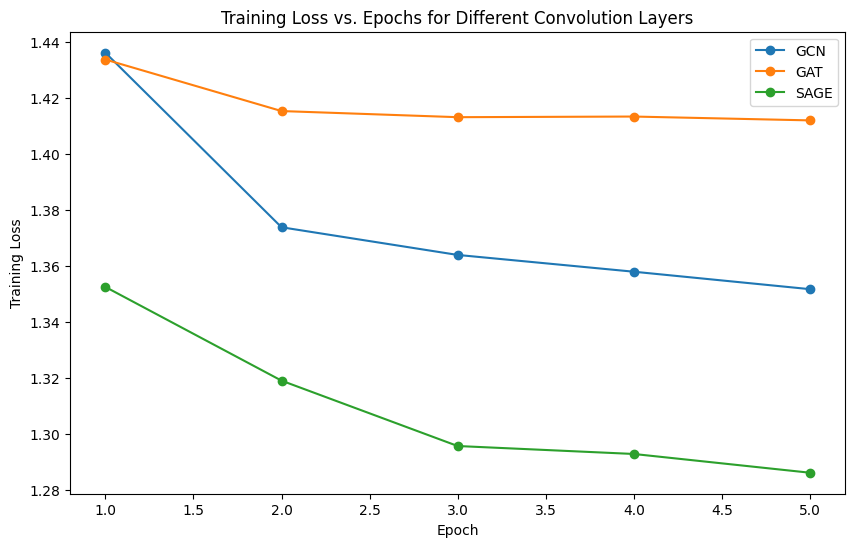

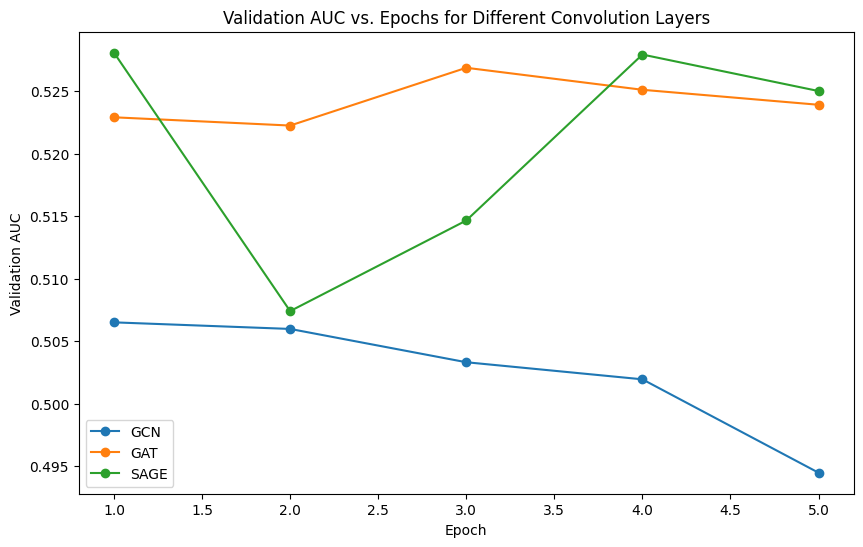

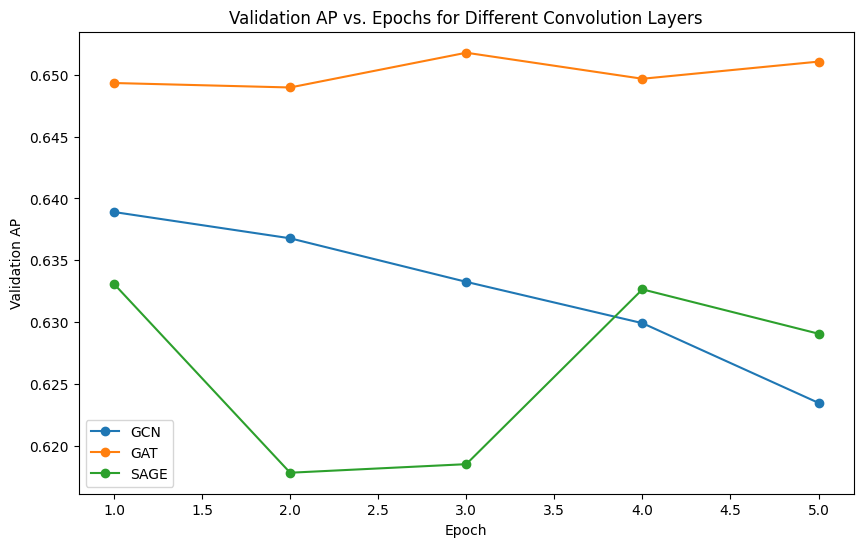

In [13]:
# Visualize Training Metrics Across Encoder Variants
epochs = range(1, num_epochs + 1)

# Plot Training Loss vs. Epochs
plt.figure(figsize=(10, 6))
for conv_name in encoder_variants.keys():
    plt.plot(epochs, metrics[conv_name]["loss"], marker='o', label=conv_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epochs for Different Convolution Layers")
plt.legend()
plt.show()

# Plot Validation AUC vs. Epochs
plt.figure(figsize=(10, 6))
for conv_name in encoder_variants.keys():
    plt.plot(epochs, metrics[conv_name]["auc"], marker='o', label=conv_name)
plt.xlabel("Epoch")
plt.ylabel("Validation AUC")
plt.title("Validation AUC vs. Epochs for Different Convolution Layers")
plt.legend()
plt.show()

# Plot Validation AP vs. Epochs
plt.figure(figsize=(10, 6))
for conv_name in encoder_variants.keys():
    plt.plot(epochs, metrics[conv_name]["ap"], marker='o', label=conv_name)
plt.xlabel("Epoch")
plt.ylabel("Validation AP")
plt.title("Validation AP vs. Epochs for Different Convolution Layers")
plt.legend()
plt.show()

### Compare the statistics (degree distribution etc.) of the training and the generated graphs.

Training VGAE...
Epoch 01 | Train Loss: 1.4236
Epoch 02 | Train Loss: 1.3826
Epoch 03 | Train Loss: 1.3775
Epoch 04 | Train Loss: 1.3735
Epoch 05 | Train Loss: 1.3690


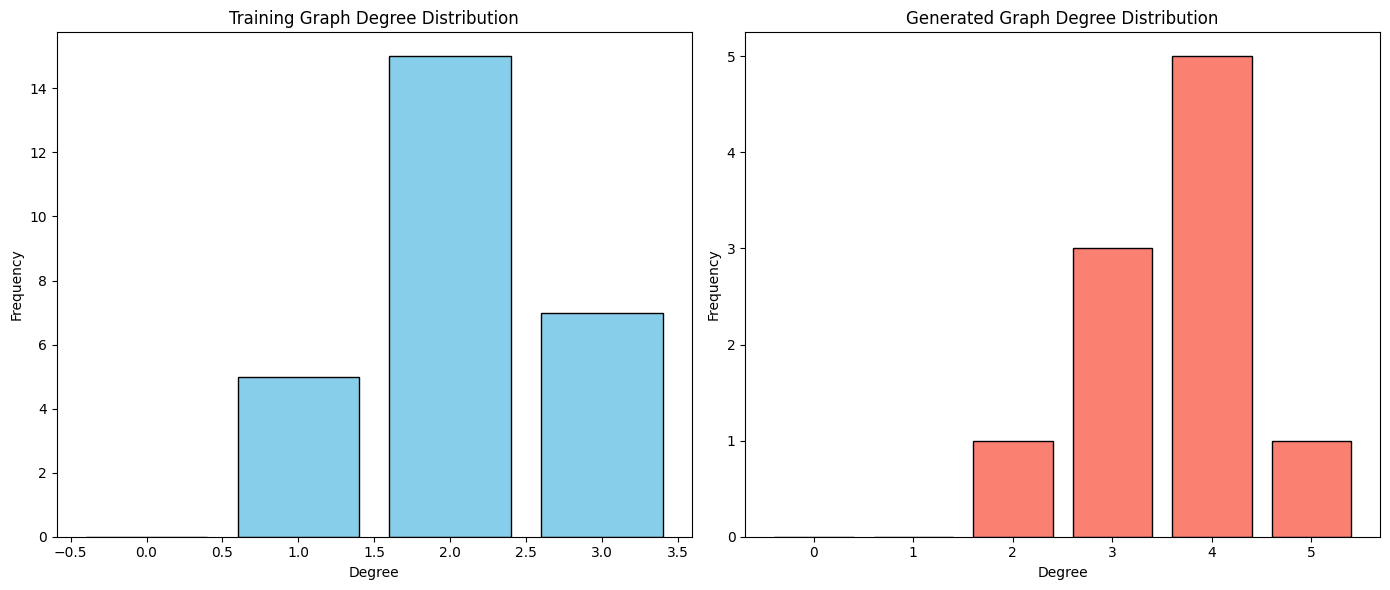

Training Graph Statistics:
  Number of Nodes: 27
  Number of Edges: 28
  Mean Degree: 2.07
  Std Dev: 0.66
  Min Degree: 1
  Max Degree: 3
----------------------------------------
Generated Graph Statistics:
  Number of Nodes: 10
  Number of Edges: 18
  Mean Degree: 3.60
  Std Dev: 0.80
  Min Degree: 2
  Max Degree: 5
----------------------------------------


In [14]:
# Train the VGAE model

model = VGAE(VariationalGCNEncoder(dataset.num_features, 16))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 5

print("Training VGAE...")
for epoch in range(1, num_epochs + 1):
    train_loss = train()
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}")


# Generate a new graph from latent space

num_nodes = 10  # Number of nodes in the generated graph
z = torch.randn(num_nodes, 16)
adj = model.decoder.forward_all(z).detach().numpy()
binary_adj = (adj > 0.5).astype(np.int32)

# Build the generated graph, avoiding self-loops and duplicate edges
G_generated = nx.Graph()
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if binary_adj[i, j] == 1:
            G_generated.add_edge(i, j)


# Build the training graph from one training sample

train_graph_data = train_data_list[0]
G_train = nx.Graph()
edge_index = train_graph_data.edge_index.cpu().numpy()
for i, j in zip(edge_index[0], edge_index[1]):
    if i != j:
        G_train.add_edge(i, j)


# Utility Functions for Visualization and Statistics

def plot_degree_distribution_side_by_side(G1, G2, title1="Graph 1 Degree Distribution", title2="Graph 2 Degree Distribution"):
    degrees1 = [d for n, d in G1.degree()]
    degrees2 = [d for n, d in G2.degree()]

    # Define bins for histogram
    bins1 = range(0, max(degrees1)+2) if degrees1 else [0, 1]
    bins2 = range(0, max(degrees2)+2) if degrees2 else [0, 1]

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].hist(degrees1, bins=bins1, align='left', rwidth=0.8, color='skyblue', edgecolor='black')
    axs[0].set_title(title1)
    axs[0].set_xlabel("Degree")
    axs[0].set_ylabel("Frequency")

    axs[1].hist(degrees2, bins=bins2, align='left', rwidth=0.8, color='salmon', edgecolor='black')
    axs[1].set_title(title2)
    axs[1].set_xlabel("Degree")
    axs[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

def print_graph_statistics(G, name="Graph"):
    degrees = [d for n, d in G.degree()]
    print(f"{name} Statistics:")
    print(f"  Number of Nodes: {G.number_of_nodes()}")
    print(f"  Number of Edges: {G.number_of_edges()}")
    if degrees:
        print(f"  Mean Degree: {np.mean(degrees):.2f}")
        print(f"  Std Dev: {np.std(degrees):.2f}")
        print(f"  Min Degree: {np.min(degrees)}")
        print(f"  Max Degree: {np.max(degrees)}")
    print("-" * 40)


# Compare the Degree Distributions

plot_degree_distribution_side_by_side(G_train, G_generated,
                                        title1="Training Graph Degree Distribution",
                                        title2="Generated Graph Degree Distribution")


# Print Graph Statistics

print_graph_statistics(G_train, "Training Graph")
print_graph_statistics(G_generated, "Generated Graph")


Training Graph:
The real training graph has 27 nodes with 28 edges, so on average, each node connects to about 2 other nodes. The connections are quite sparse.

Generated Graph:
The generated graph is smaller with only 10 nodes, but it has 18 edges. This means each node connects to about 3 to 4 other nodes on average, making it much denser.

Overall:
The generated graph is more tightly connected than the training graph, even though it has fewer nodes.